In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))


import numpy as np
from scipy.optimize import minimize
import networkx as nx

import qiskit 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from shared.QiskitMaxcut import *
from qiskit.utils import QuantumInstance
from qiskit.result import Result
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, QNSPSA


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')
# https://arxiv.org/pdf/2011.10860.pdf

In [2]:
from shared.graph_helper import load_nx_graph_from, generate_butterfly_graph

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/simulator/'))

In [5]:
from shared.gem.gem_instance import GEMInstance
from shared.gem.gem_quantum_instance import GEMQuantumInstance
from shared.gem.gem_minimum_eigen_optimizer import GEMMinimumEigenOptimizer

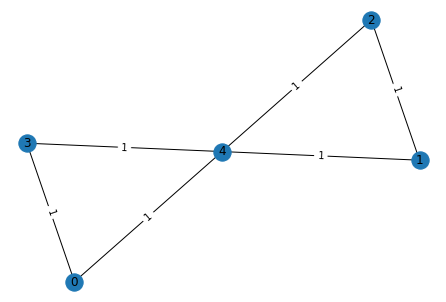

In [6]:
G = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(G,-4)
max_cut.draw()
qubo = max_cut.to_qubo()

In [7]:
# Minimum 
initial_point=[ 3.74802914, 5.97548754]

In [8]:
maxiter=0
shots=8192

# Simulator 

In [9]:
gem = GEMInstance()

In [10]:
%matplotlib inline

def my_plot_histogram(distribution, mean):
    from matplotlib.ticker import FixedLocator, FixedFormatter
    from qiskit.tools.visualization import plot_histogram
    fig = plot_histogram(distribution, title=f"Max-Cut Distribution (Ø: {mean:.3f})", bar_labels=False)
    ax = fig.axes[0]
    x_locator = FixedLocator([0, len(distribution.keys())//2, len(distribution.keys())])
    x_formatter = FixedFormatter([
        ""+str(min(distribution.keys())), ""+str(list(distribution.keys())[len(distribution.keys())//2]), ""+str(max(distribution.keys()))])
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    plt.show()
    return fig

optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (26) is too large to display. Skip.
Expectation Value: -3.9246109579646533
Highest Exp.Value: 0 with 0.9129 %
Lowest Exp.Value: -4 with 97.143 %
Highest Probability: -4 with 97.143 %
Ratio r: 0.9811527394911633
Approiximation ratio: 0.9811527394911633
MSE: 6.370794006184287
RMSE: 2.5240431862756005


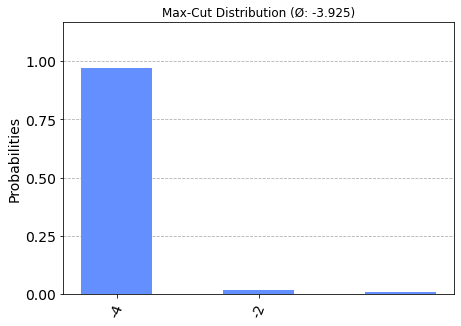

In [11]:
# QAOA with GEM
qiGME = GEMQuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=shots)
qaoa = QAOA(quantum_instance=qiGME, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))

result = GEMMinimumEigenOptimizer(qaoa,gem).solve(qubo)
mean, distribution_noise_gem_sim = max_cut.analyse(result, print_output=True)
my_plot_histogram(distribution_noise_gem_sim, mean)

In [12]:
# print MG-Matrix 
qiGME.MG

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (24) is too large to display. Skip.
Expectation Value: -3.926025390625
Highest Exp.Value: 0 with 0.91553 %
Lowest Exp.Value: -4 with 97.217 %
Highest Probability: -4 with 97.217 %
Ratio r: 0.98150634765625
Approiximation ratio: 0.98150634765625
MSE: 6.376240471998851
RMSE: 2.5251218727021576


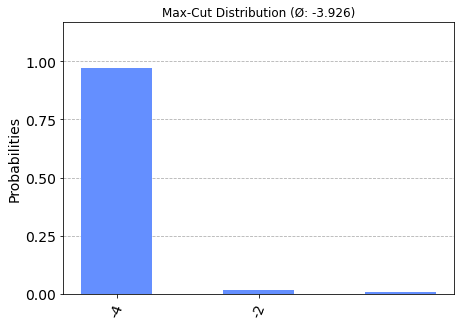

In [13]:
# Normal QAOA 
qi = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=shots)
qaoa = QAOA(quantum_instance=qi, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
mean, distribution_sim = max_cut.analyse(result, print_output=True)
my_plot_histogram(distribution_sim, mean)

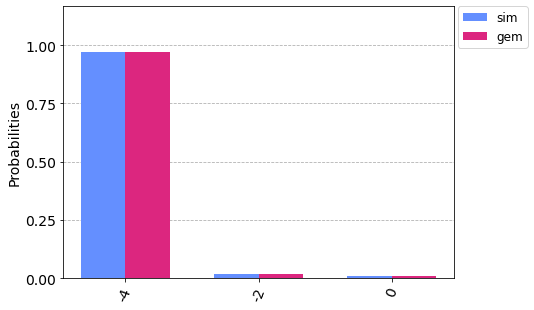

In [14]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([distribution_sim, distribution_noise_gem_sim], legend=['sim','gem'], bar_labels=False)

# IBM Sydney 

## GEM

In [32]:
gem = GEMInstance()

optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (23) is too large to display. Skip.
Expectation Value: -3.8558605217202446
Highest Exp.Value: -2 with 7.207 %
Lowest Exp.Value: -4 with 92.793 %
Highest Probability: -4 with 92.793 %
Ratio r: 0.9279302608601223
Approiximation ratio: 0.9639651304300612
MSE: 1.7324972326392492
RMSE: 1.316243606874977


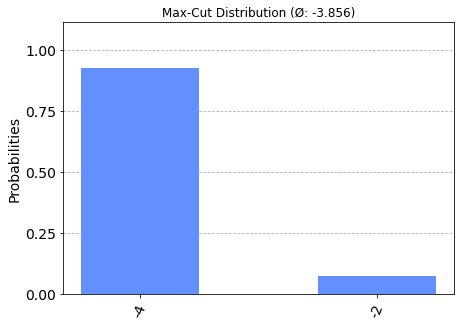

In [33]:
# QAOA with GEM
qiGME = GEMQuantumInstance(backend=provider.get_backend('ibmq_sydney'), shots=shots)
qaoa = QAOA(quantum_instance=qiGME, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))

result = GEMMinimumEigenOptimizer(qaoa, gem).solve(qubo)
mean_gem, distribution_gem = max_cut.analyse(result, print_output=True)
my_plot_histogram(distribution_gem, mean_gem)

In [34]:
# print MG-Matrix 
qiGME.MG

array([[0.60900879, 0.03356934, 0.10308838, ..., 0.00268555, 0.00146484,
        0.00268555],
       [0.0189209 , 0.57409668, 0.01049805, ..., 0.00164795, 0.00262451,
        0.00152588],
       [0.08886719, 0.01324463, 0.58642578, ..., 0.00158691, 0.00189209,
        0.00469971],
       ...,
       [0.00219727, 0.00152588, 0.00128174, ..., 0.54180908, 0.00762939,
        0.09741211],
       [0.00152588, 0.00231934, 0.00170898, ..., 0.01269531, 0.54656982,
        0.03533936],
       [0.00213623, 0.0012207 , 0.0020752 , ..., 0.08404541, 0.02325439,
        0.53466797]])

## EM

In [18]:
qiEM = QuantumInstance(backend=provider.get_backend('ibmq_sydney'),
                     measurement_error_mitigation_cls=CompleteMeasFitter,
                     measurement_error_mitigation_shots=shots,
                     shots=shots,
                     )

optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -3.753275885128407
Highest Exp.Value: 0 with 0.74932 %
Lowest Exp.Value: -4 with 88.413 %
Highest Probability: -4 with 88.413 %
Ratio r: 0.9383189712821017
Approiximation ratio: 0.9383189712821017
MSE: 5.740642996039465
RMSE: 2.3959638970651174


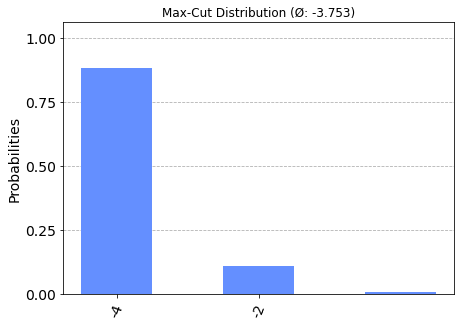

In [19]:
qaoa = QAOA(quantum_instance=qiEM, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
mean_em, distribution_em = max_cut.analyse(result, print_output=True)
my_plot_histogram(distribution_em, mean_em)

In [20]:
## # Without any Error mitigation

optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -3.693359375
Highest Exp.Value: 0 with 1.0376 %
Lowest Exp.Value: -4 with 85.706 %
Highest Probability: -4 with 85.706 %
Ratio r: 0.92333984375
Approiximation ratio: 0.92333984375
MSE: 5.534132639567058
RMSE: 2.352473727710271


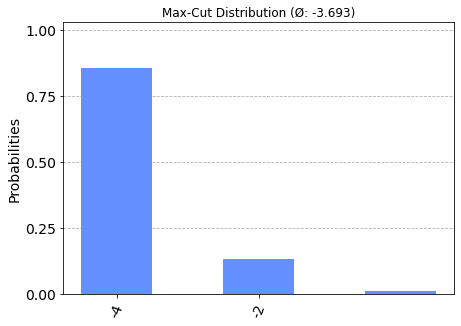

In [21]:
qi = QuantumInstance(backend=provider.get_backend('ibmq_sydney'),
                     shots=shots,
                     )
qaoa = QAOA(quantum_instance=qi, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
mean_noise, distribution_noise = max_cut.analyse(result, print_output=True)
my_plot_histogram(distribution_noise, mean_noise)

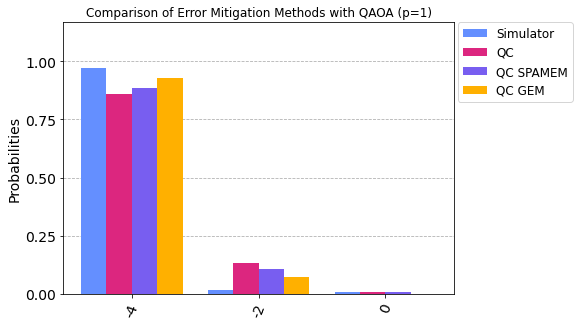

In [35]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([distribution_sim, distribution_noise, distribution_em, distribution_gem],
               title=f"Comparison of Error Mitigation Methods with QAOA (p=1)",
               legend=['Simulator','QC', 'QC SPAMEM','QC GEM'], bar_labels=False)    

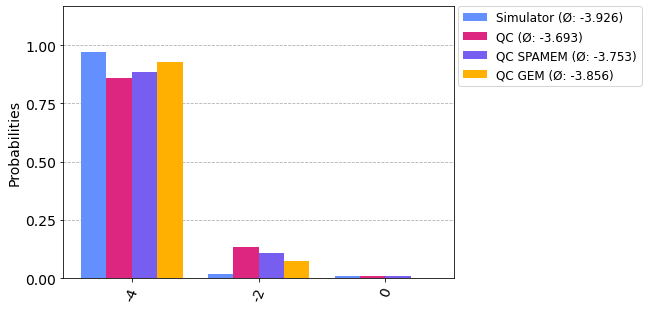

In [36]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([distribution_sim, distribution_noise, distribution_em, distribution_gem],
               legend=[f'Simulator (Ø: {mean:.3f})',f'QC (Ø: {mean_noise:.3f})', f'QC SPAMEM (Ø: {mean_em:.3f})',f'QC GEM (Ø: {mean_gem:.3f})'], bar_labels=False)   

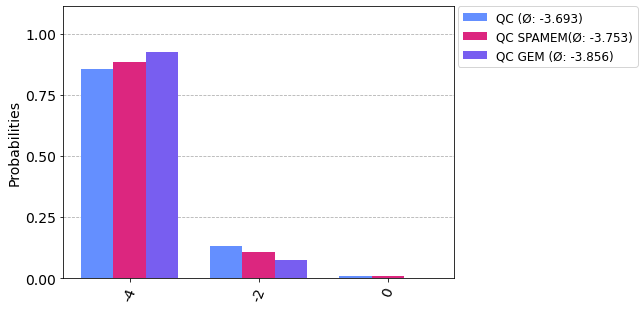

In [37]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([distribution_noise, distribution_em, distribution_gem],
               legend=[f'QC (Ø: {mean_noise:.3f})', f'QC SPAMEM(Ø: {mean_em:.3f})',f'QC GEM (Ø: {mean_gem:.3f})'], bar_labels=False)   

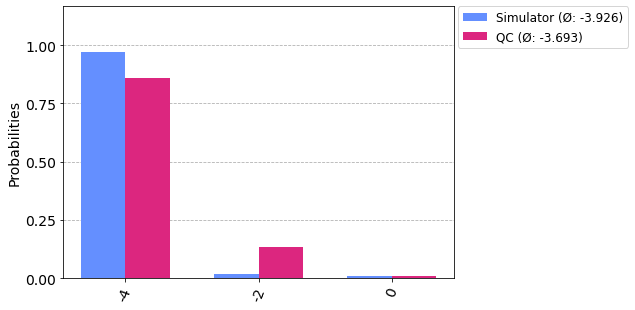

In [31]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([distribution_sim, distribution_noise],
               legend=[f'Simulator (Ø: {mean:.3f})',f'QC (Ø: {mean_noise:.3f})'], bar_labels=False)   

In [38]:
abs( mean_noise / mean - 1 ) * 100 

5.926248367638831

In [39]:
abs( mean_em / mean - 1 ) * 100 

4.400111774852588

In [40]:
abs( mean_gem / mean - 1 ) * 100 

1.7871730802430097